In [1]:
# !pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [33]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy

import yaml

import jax
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import flax.linen as nn

from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params, generate_decoder_samples


In [28]:
import tikzplotlib

output_path = r"output_tex/"

## Fit model to the boarding school data

In R:

`library(outbreaks)`

`df = influenza_england_1978_school`

Priors for beta and gamma are borrowed from here:
    https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html#1_simple_sir

    beta ~ normal(2, 1); //truncated at 0
    gamma ~ normal(0.4, 0.5); //truncated at 0

## Data

In [2]:
# Define observed data (e.g., number of reported cases over time)
observed_data = jnp.array([3,8,26,76,225,298,258,233,189,128,68,29,14,4])

#observed_data = jnp.fmax(sim_observations, 0)
num_days = len(observed_data)

N = 763

z_init = jnp.array([N - 1.0, 1.0, 0.0])

## Define model - ODE

In [3]:
#def dz_dt(z, t, beta, gamma, N):
def dz_dt(z, t, beta, gamma):
    """
    Susceptible-Infectious (SIS) model.

    Args:
        beta: Infection rate (transmission rate).
        gamma: Recovery rate.

    Returns:
        S, I, R : Arrays representing the number of susceptible, infected, and recovered individuals
                 at each time step.
    """
    # Initial conditions
    S = z[0]
    I = z[1]
    R = z[2]

    #N = S + I + R
    # hardcode N!!! -> change this in the future
    N = 763

    dS_dt = -beta * I * S / N;
    dI_dt =  beta * I * S / N - gamma * I;
    dR_dt =  gamma * I;

    return jnp.stack([dS_dt, dI_dt, dR_dt])

In [4]:
def model(num_days, z_init=None, beta=None, gamma=None, n_states=3, observed_data=None, 
          dist_beta  = dist.TruncatedNormal(loc=2,  scale=1,low=0.),
          dist_gamma = dist.TruncatedNormal(loc=0.4,scale=0.5,low=0.)
          ):
    """
    :param int num_days: number of measurement times
    :param numpy.ndarray y: measured populations with shape (num_days, n_states)

    Priors for beta and gamma are borrowed from here:
    https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html#1_simple_sir

    beta ~ normal(2, 1); //truncated at 0
    gamma ~ normal(0.4, 0.5); //truncated at 0
    """

    # initial population
    if z_init == None:
        z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([n_states]))

    # measurement times
    ts = jnp.arange(float(num_days))

    # parameters beta, gamma of dz_dt
    if beta == None:
        beta = numpyro.sample("beta", dist_beta)

    if gamma == None:
        gamma = numpyro.sample("gamma", dist_gamma)

    # integrate dz/dt, the result will have shape num_days x 2
    z = numpyro.deterministic("z", odeint(dz_dt, z_init, ts, beta, gamma, rtol=1e-6, atol=1e-5, mxstep=1000))

    phi_inv = numpyro.sample("phi_inv", dist.Exponential(5))
    phi = numpyro.deterministic("phi", 1./phi_inv)

    # Likelihood
    #obs = numpyro.sample("observed", dist.Poisson(z[:, 1]), obs=observed_data)
    obs = numpyro.sample("observed", dist.NegativeBinomial2(z[:, 1], phi), obs=observed_data)

## ODE - inference

In [5]:
# use dense_mass for better mixing rate
mcmc_ode = MCMC(
        NUTS(model, dense_mass=True),
        num_warmup=1000,
        num_samples=1000,
        num_chains=1,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )

In [6]:
mcmc_ode.run(rng_key=PRNGKey(18), num_days = num_days, z_init = z_init, observed_data=observed_data)

sample: 100%|██████████| 2000/2000 [00:07<00:00, 250.45it/s, 3 steps of size 5.55e-01. acc. prob=0.94]


In [7]:
mcmc_ode.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.06      0.08      2.06      1.94      2.18    441.82      1.01
     gamma      0.51      0.04      0.51      0.44      0.57    675.58      1.00
   phi_inv      0.11      0.07      0.10      0.02      0.22    567.89      1.00

Number of divergences: 0


In [8]:
# Get posterior samples
posterior_samples_ode = mcmc_ode.get_samples()

In [9]:
# posterior predictive
sir_posterior_predictive_ode = Predictive(model, posterior_samples_ode)(PRNGKey(11), num_days = num_days, z_init = z_init)
observed_posterior_predictive_ode = sir_posterior_predictive_ode['observed']
observed_posterior_mean_ode = observed_posterior_predictive_ode.mean(axis=0)
observed_posterior_25_ode = np.quantile(observed_posterior_predictive_ode, 0.05, axis=0)
observed_posterior_75_ode = np.quantile(observed_posterior_predictive_ode, 0.95, axis=0)

In [10]:
#plt.scatter(range(num_days), observed_data, label='data')
#plt.plot(range(num_days), observed_posterior_mean_ode, label="ODE, mean", color= "red")
#plt.fill_between(range(num_days), observed_posterior_25_ode, observed_posterior_75_ode, alpha=0.4, interpolate=True, label="ODE, 95% BCI", color="orange")
#plt.legend()

## Define model - PriorCVAE

In [12]:
output_dir = "01-09-49/"

In [14]:
cfg_path = os.path.join(output_dir, ".hydra", "config.yaml")

with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

latent_dim = cfg_data["latent_dim"]
conditional = cfg_data["conditional"]
dec_activation_fn = cfg_data["dec_activation"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]

output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

In [15]:
def model(num_days, z_init=None, beta=None, gamma=None, n_states=3, observed_data=None,
          latent_dim = latent_dim,
          dist_beta  = dist.TruncatedNormal(loc=2,  scale=1,low=0.),
          dist_gamma = dist.TruncatedNormal(loc=0.4,scale=0.5,low=0.)):
    """
    :param int num_days: number of measurement times
    :param numpy.ndarray y: measured populations with shape (num_days, n_states)

    Priors for beta and gamma are borrowed from here:
    https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html#1_simple_sir

    beta ~ normal(2, 1); //truncated at 0
    gamma ~ normal(0.4, 0.5); //truncated at 0
    """

    # initial population
    #if z_init == None:
    #    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([n_states]))

    # measurement times
    ts = jnp.arange(float(num_days))

    # parameters beta, gamma of dz_dt
    if beta == None:
        beta = numpyro.sample("beta", dist_beta)

    if gamma == None:
        gamma = numpyro.sample("gamma", dist_gamma)

    c = jnp.array([beta, gamma]).reshape((2, ))

    z = numpyro.sample("z", dist.Normal(jnp.zeros(latent_dim), jnp.ones(latent_dim)))
    z = jnp.concatenate([z, c]) 
    #z = z.reshape((1, -1))

    N = 763
    f = decoder.apply({'params': trained_decoder_params}, z)
    f = numpyro.deterministic("infected", nn.sigmoid(f) * N)  #Last layer activation
    
    phi_inv = numpyro.sample("phi_inv", dist.Exponential(5))
    phi = numpyro.deterministic("phi", 1./phi_inv);

    # Likelihood
    obs = numpyro.sample("observed", dist.NegativeBinomial2(f, phi), obs=observed_data)
    #obs = numpyro.sample("observed", dist.Poisson(f), obs=observed_data)

## Inference - PriorCVAE

In [16]:
# use dense_mass for better mixing rate
mcmc_vae = MCMC(
        NUTS(model, dense_mass=True),
        num_warmup=1000,
        num_samples=1000,
        num_chains=1,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )

In [17]:
mcmc_vae.run(rng_key=PRNGKey(11),
         num_days = num_days,
         z_init = z_init,
         observed_data=observed_data)

sample: 100%|██████████| 2000/2000 [00:05<00:00, 344.15it/s, 7 steps of size 4.42e-01. acc. prob=0.92]  


In [18]:
mcmc_vae.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.39      0.23      2.39      2.03      2.77    712.84      1.00
     gamma      0.65      0.16      0.65      0.39      0.91    560.44      1.00
   phi_inv      0.19      0.11      0.17      0.05      0.34    784.66      1.00
      z[0]      0.03      0.83     -0.02     -1.39      1.36    654.06      1.00
      z[1]     -0.01      0.79     -0.00     -1.39      1.27    783.68      1.00
      z[2]      0.08      1.02      0.08     -1.43      1.81    832.77      1.00
      z[3]      0.00      0.98      0.01     -1.53      1.65   1125.32      1.00
      z[4]     -0.02      0.96      0.00     -1.56      1.61   1116.85      1.00
      z[5]     -0.02      1.04     -0.01     -1.58      1.86   1104.15      1.00

Number of divergences: 0


In [19]:
# Get posterior samples
posterior_samples_vae = mcmc_vae.get_samples()

In [20]:
# posterior predictive
sir_posterior_predictive_vae = Predictive(model, posterior_samples_vae)(PRNGKey(11), num_days = num_days, z_init = z_init)
observed_posterior_predictive_vae = sir_posterior_predictive_vae['observed']
observed_posterior_mean_vae = observed_posterior_predictive_vae.mean(axis=0)
observed_posterior_25_vae = np.quantile(observed_posterior_predictive_vae, 0.05, axis=0)
observed_posterior_75_vae = np.quantile(observed_posterior_predictive_vae, 0.95, axis=0)

In [21]:
#plt.scatter(range(num_days), observed_data, label='data')
#plt.plot(range(num_days), observed_posterior_mean_vae[:,], label="Infected, mean", color= "red")
#plt.fill_between(range(num_days), observed_posterior_25_vae[:,], observed_posterior_75_vae[:,], alpha=0.4, interpolate=True, label="Infected, 95% BCI", color="orange")

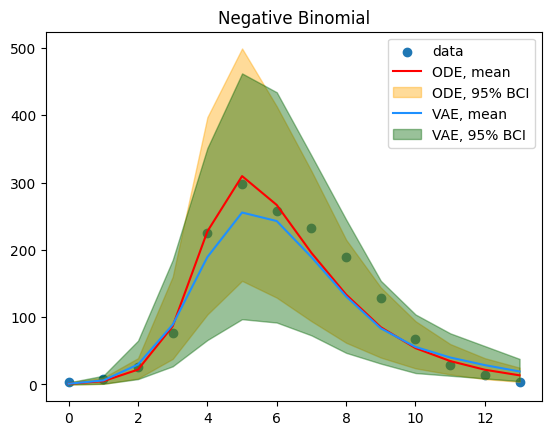

In [22]:
plt.scatter(range(num_days), observed_data, label='data')
plt.plot(range(num_days), observed_posterior_mean_ode, label="ODE, mean", color= "red")
plt.fill_between(range(num_days), observed_posterior_25_ode, observed_posterior_75_ode, alpha=0.4, interpolate=True, label="ODE, 95% BCI", color="orange")

plt.plot(range(num_days), observed_posterior_mean_vae[:,], label="VAE, mean", color="dodgerblue")
plt.fill_between(range(num_days), observed_posterior_25_vae[:,], observed_posterior_75_vae[:,], alpha=0.4, interpolate=True, label="VAE, 95% BCI", color="darkgreen")

#plt.title('Poisson')
plt.title('Negative Binomial')
plt.legend()

In [29]:
mcmc_ode.print_summary()
mcmc_vae.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.06      0.08      2.06      1.94      2.18    441.82      1.01
     gamma      0.51      0.04      0.51      0.44      0.57    675.58      1.00
   phi_inv      0.11      0.07      0.10      0.02      0.22    567.89      1.00

Number of divergences: 0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.39      0.23      2.39      2.03      2.77    712.84      1.00
     gamma      0.65      0.16      0.65      0.39      0.91    560.44      1.00
   phi_inv      0.19      0.11      0.17      0.05      0.34    784.66      1.00
      z[0]      0.03      0.83     -0.02     -1.39      1.36    654.06      1.00
      z[1]     -0.01      0.79     -0.00     -1.39      1.27    783.68      1.00
      z[2]      0.08      1.02      0.08     -1.43      1.81    832.77      1.00
      z[3]      0.00      0.98      0.01     -1.53      1.65   1125.32      1.00


In [30]:
beta_ode = posterior_samples_ode['beta']
beta_vae = posterior_samples_vae['beta']

gamma_ode = posterior_samples_ode['gamma']
gamma_vae = posterior_samples_vae['gamma']

phi_inv_ode = posterior_samples_ode['phi_inv']
phi_inv_vae = posterior_samples_vae['phi_inv']

In [31]:
# priors
sir_predictive = Predictive(model, num_samples=1000)
rng_key_draw = PRNGKey(18)
sir_sims = sir_predictive(rng_key=rng_key_draw, num_days = num_days, z_init = z_init)

beta_prior = sir_sims['beta']
gamma_prior = sir_sims['gamma']
phi_inv_prior = sir_sims['phi']

In [51]:
#plt.hist(beta_ode, bins=20, label='beta, ODE', alpha=0.5, density=True)
#plt.hist(beta_vae, bins=20, label='beta, PriorCVAE', alpha=0.5, density=True)
#plt.hist(beta_prior, bins=20, label='beta, prior', alpha=0.5, density=True)
#plt.legend()

<Figure size 640x480 with 0 Axes>

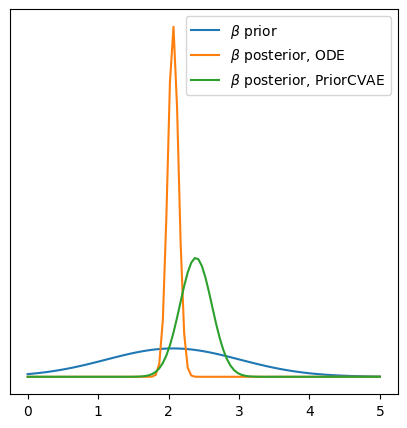

In [62]:
beta_prior_mean = np.mean(beta_prior)
beta_prior_sigma = np.std(beta_prior)

beta_ode_mean = np.mean(beta_ode)
beta_ode_sigma = np.std(beta_ode)

beta_vae_mean = np.mean(beta_vae)
beta_vae_sigma = np.std(beta_vae)

x_tmp = np.linspace(-0.001, 5, 100)

plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
#plt.hlines(1, x_tmp[0], x_tmp[-1], color="tab:red", linestyle="dashed")
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, beta_prior_mean, beta_prior_sigma), label=r'$\beta$ prior')
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, beta_ode_mean, beta_ode_sigma), label=r'$\beta$ posterior, ODE ')
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, beta_vae_mean, beta_vae_sigma), label=r'$\beta$ posterior, PriorCVAE')

#plt.xlim([0, 1])
#plt.ylim([0, 3])
#plt.xticks([])
plt.yticks([])

plt.legend()

#output_tik_path = os.path.join(output_path, "SIR", f"SIR_beta_posterior.tex")
#tikzplotlib.save(output_tik_path,
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 tex_relative_path_to_data='fig/',
#                 figure=fig)

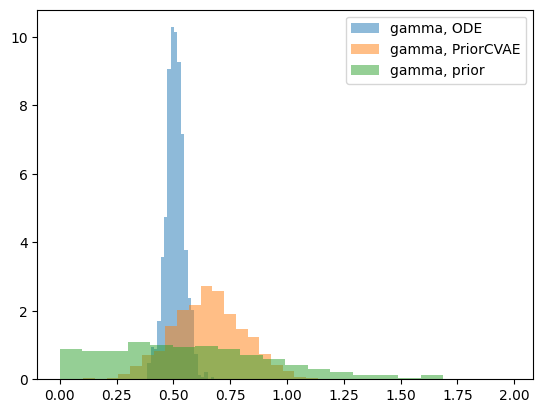

In [56]:
plt.hist(gamma_ode, bins=20, label='gamma, ODE', alpha=0.5, density=True)
plt.hist(gamma_vae, bins=20, label='gamma, PriorCVAE', alpha=0.5, density=True)
plt.hist(gamma_prior, bins=20, label='gamma, prior', alpha=0.5, density=True)
plt.legend()

<Figure size 640x480 with 0 Axes>

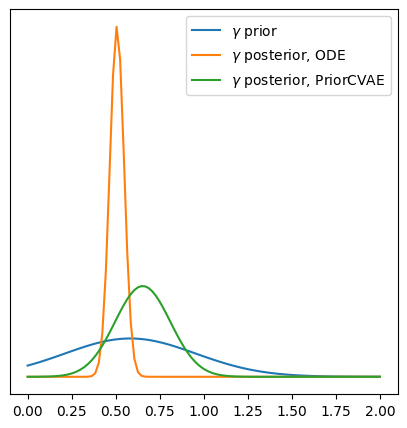

In [64]:
gamma_prior_mean = np.mean(gamma_prior)
gamma_prior_sigma = np.std(gamma_prior)

gamma_ode_mean = np.mean(gamma_ode)
gamma_ode_sigma = np.std(gamma_ode)

gamma_vae_mean = np.mean(gamma_vae)
gamma_vae_sigma = np.std(gamma_vae)

x_tmp = np.linspace(-0.001, 2, 100)

plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
#plt.hlines(1, x_tmp[0], x_tmp[-1], color="tab:red", linestyle="dashed")
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, gamma_prior_mean, gamma_prior_sigma), label=r'$\gamma$ prior')
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, gamma_ode_mean,   gamma_ode_sigma),   label=r'$\gamma$ posterior, ODE ')
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, gamma_vae_mean,   gamma_vae_sigma),   label=r'$\gamma$ posterior, PriorCVAE')

#plt.xlim([0, 1])
#plt.ylim([0, 3])
#plt.xticks([])
plt.yticks([])

plt.legend()

#output_tik_path = os.path.join(output_path, "SIR", f"SIR_beta_posterior.tex")
#tikzplotlib.save(output_tik_path,
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 tex_relative_path_to_data='fig/',
#                 figure=fig)

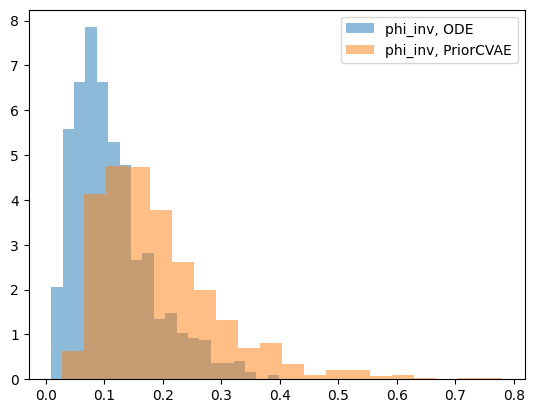

In [49]:
#plt.hist(phi_inv_ode, bins=20, label='phi_inv, ODE', alpha=0.5, density=True)
#plt.hist(phi_inv_vae, bins=20, label='phi_inv, PriorCVAE', alpha=0.5, density=True)
#plt.legend()



In [ ]:
output_tik_path = os.path.join(output_path, "MCMC", f"SIR_posterior_fits.tex")

tikzplotlib.save(output_tik_path,
                 figurewidth='\\figurewidth', figureheight='\\figureheight',
                 tex_relative_path_to_data='fig/',
                 figure=fig)